In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 32.8 MB/s 
     |████████████████████████████████| 6.6 MB 59.8 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 596 kB 62.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from transformers import AutoTokenizer, AdamW, BertForTokenClassification
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch
import pandas as pd
import re
import numpy as np
from nltk.tokenize import WordPunctTokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [3]:
def text_labeling(path_to_abstracts, path_to_entities, nltk_tokenizer):
    abstracts = pd.read_csv(path_to_abstracts, sep='\t', names=['index', 'headline', 'text'], index_col=False)
    entities = pd.read_csv(path_to_entities, sep='\t',
                           names=['index', 'num', 'label', 'start_span', 'end_span', 'name'], index_col=False)

    # получаем таблицу со столбцами index | text
    abstracts['text'] = abstracts['headline'] + ' ' + abstracts['text']
    del abstracts['headline']

    sentences = []
    labels = []

    for article_index in tqdm(abstracts.values[:, 0]):
        df_filter = abstracts['index'].isin([article_index])
        assert len(abstracts[df_filter]) == 1  # проверка, что мы взяли только один текст

        text = abstracts[df_filter].values[0, 1]
        text = text.split('. ')
        text = [t + '.' for t in text]  # получили разбивку на предложения

        sents = [nltk_tokenizer.tokenize(t) for t in text]
        labs = [['O'] * len(sent) for sent in sents]  # массив пусты меток

        df_filter = entities['index'].isin([article_index])
        df = entities[df_filter]
        names, tags = df.values[:, 5], df.values[:, 2]

        try:
            arr = []
            for n in names:
                if type(n) is str:
                    arr.append(n)
                else:
                    arr.append("NA")
            names = arr # в файле сокращение NA распознается pandas как nan, исправляем это
            tok_names = [nltk_tokenizer.tokenize(n) for n in names if
                         n is not float('nan')]  # токенизируем размеченные слова (они могут состоять из словосочетаний)
        except:
            print('Error in tag tokenization, labels:', names)
            break
        # переносим разметку на данные
        for i, entity in enumerate(tok_names):
            for j, sent in enumerate(sents):
                if all([e in sent for e in entity]):
                    mass = [sent.index(e) for e in entity]
                    if mass == [p for p in range(mass[0], mass[0] + len(mass))]:
                        for m in mass:
                            labs[j][m] = tags[i]
                        break

        # добавляем предложения и разменку в основной массив
        for i in range(len(labs)):
            labels.append(labs[i])
            sentences.append(sents[i])
    return sentences, labels

In [4]:
def encode_tags(tags, encodings):
    label_types = ['O','CHEMICAL', 'GENE-N', 'GENE-Y']
    tag2id = {t: i for i, t in enumerate(label_types)}

    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    err = 0
    j = 0
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):
        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset),dtype=int) * -100
        arr_offset = np.array(doc_offset)

        # set labels whose first offset position is 0 and the second is not 0
        try:
            doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
        except:
            for i,lab in enumerate(doc_labels):
                word_number = 0
                for k in arr_offset:
                    if k[0] == 0 & k[1] != 0 & word_number == i:
                        doc_enc_labels[arr_offset.index(k)] = lab
                    elif k[0] == 0 & k[1] != 0:
                        word_number+=1
            err+=1
            continue
        encoded_labels.append(doc_enc_labels.tolist())
        j+=1
    print("Labeling error rate: ",err)
    return encoded_labels

In [5]:
tk = WordPunctTokenizer()
sent, lab = text_labeling('chemprot_training_abstracts.tsv',
                          'chemprot_training_entities.tsv',
                          tk)
label_types = ['O','CHEMICAL', 'GENE-N', 'GENE-Y']
tag2idx = {t: i for i, t in enumerate(label_types)}
idx2tag = {i: t for t, i in tag2idx.items()}

NUM_LABELS = len(label_types)
batch_size = 16
val_batch_size = 32
sequence_length = 256

train_texts, val_texts, train_tags, val_tags = train_test_split(sent, lab, test_size=.1)

100%|██████████| 1020/1020 [00:04<00:00, 214.66it/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = BertForTokenClassification.from_pretrained('bert-base-uncased',num_labels=NUM_LABELS)
model.to(device)

In [ ]:
train_encodings = tokenizer(train_texts, is_split_into_words=True,
                            return_offsets_mapping=True, padding=True, truncation=True,max_length=256)

val_encodings = tokenizer(val_texts, is_split_into_words=True,
                          return_offsets_mapping=True, padding=True, truncation=True,max_length=256)

train_labels = encode_tags(train_tags, train_encodings)
val_labels = encode_tags(val_tags, val_encodings)

train_encodings.pop("offset_mapping")
val_encodings.pop("offset_mapping")

In [8]:
class NER_Dataloader(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self,idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = NER_Dataloader(train_encodings, train_labels)
val_dataset = NER_Dataloader(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=val_batch_size)

In [9]:
optim = AdamW(model.parameters(), lr=5e-5)

epoch_train_loss = []
step_train_loss = []

epoch_val_loss = []
step_val_loss = []

for epoch in tqdm(range(4)):
    model.train()
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]

        step_train_loss.append(loss.item())

        loss.backward()
        optim.step()

    epoch_train_loss.append(sum(step_train_loss)/len(step_train_loss))

    with torch.no_grad():
        for batch in val_loader:
            model.eval()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            
            step_val_loss.append(loss.item())
            
        epoch_val_loss.append(sum(step_val_loss)/len(step_val_loss))


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 4/4 [27:12<00:00, 408.16s/it]


In [ ]:
#сохраняем модель
model.save_pretrained('./NER/saved_model/')

Графики обучения модели.

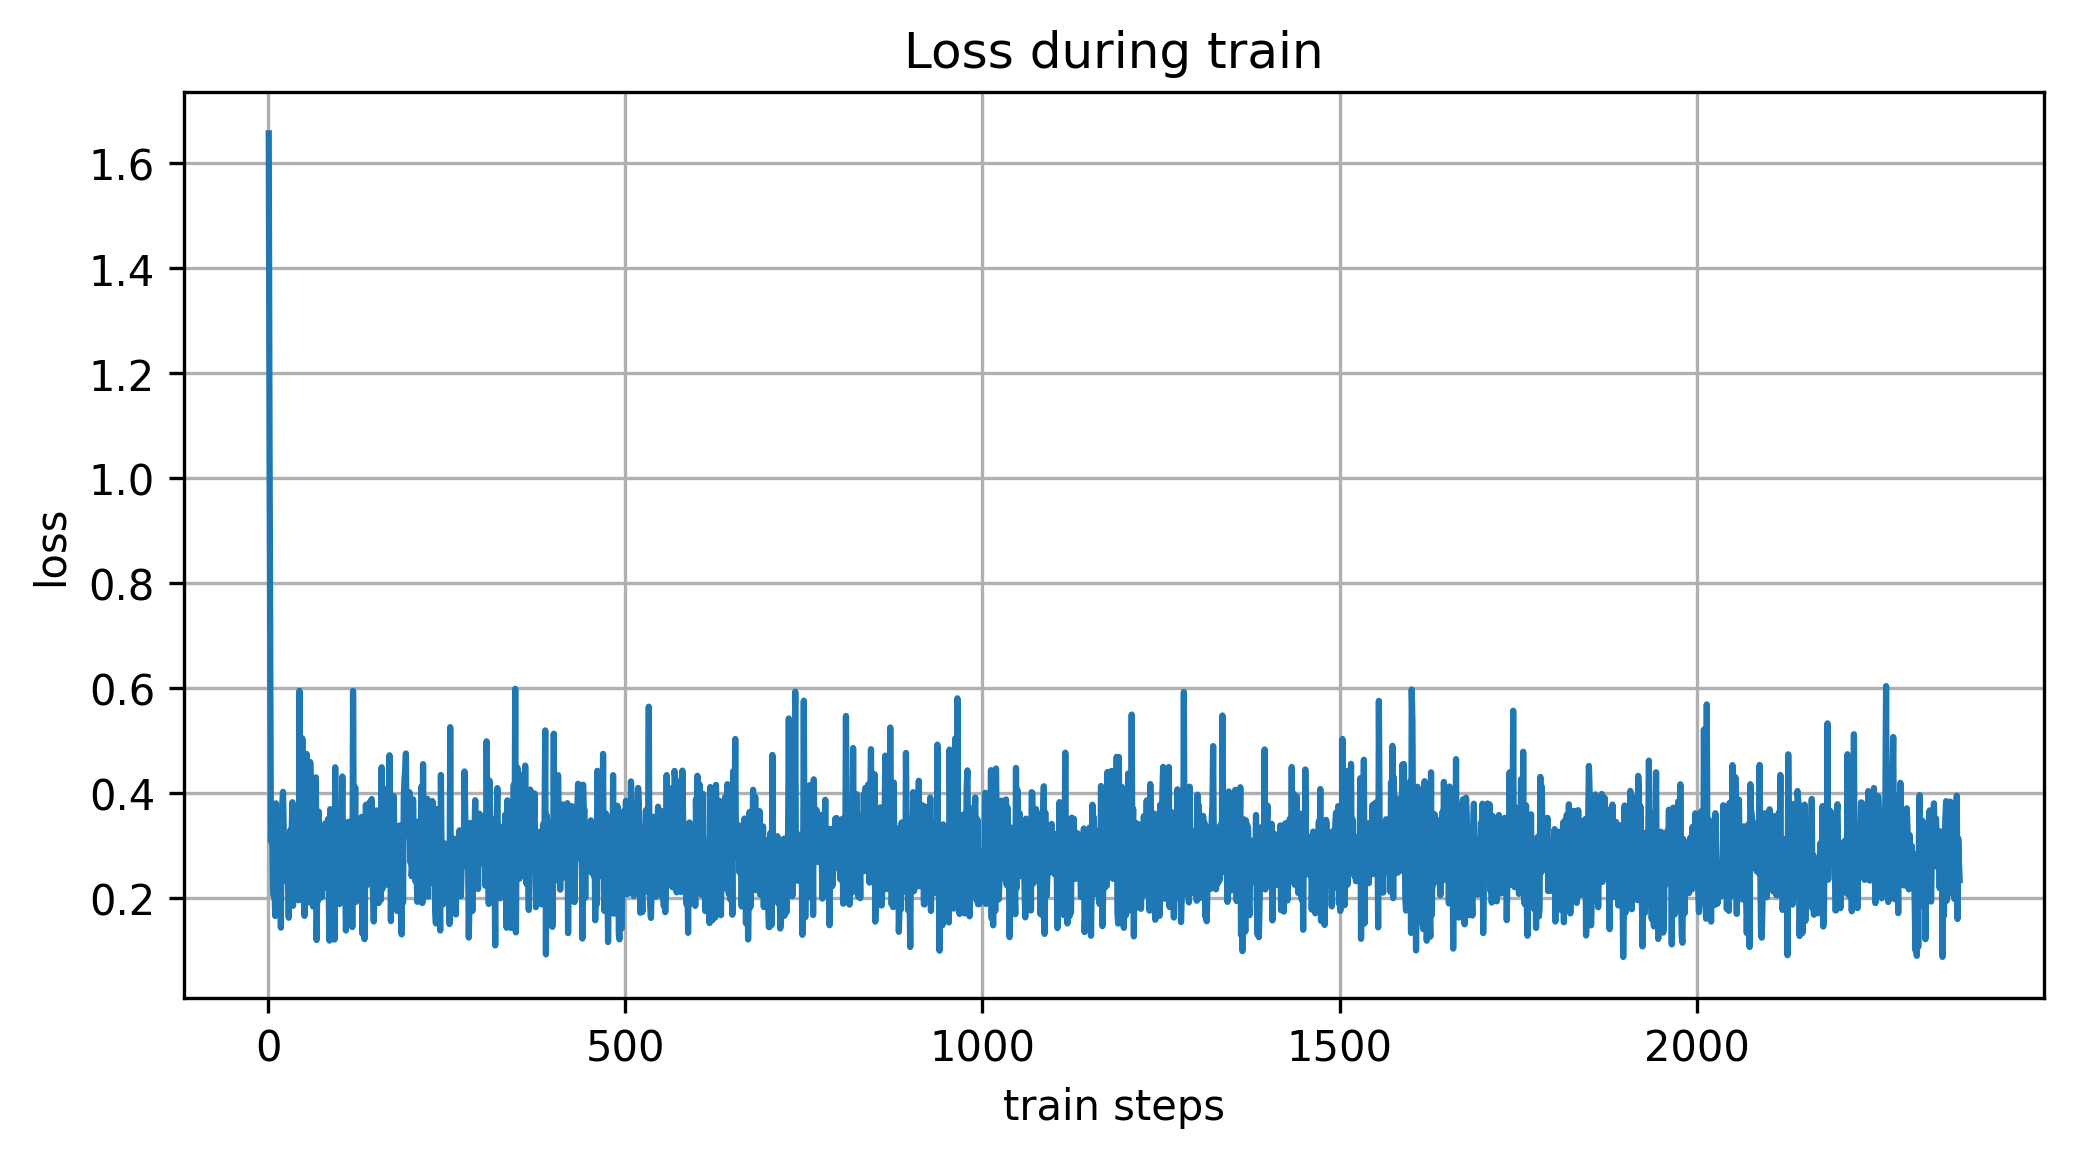

In [23]:
y = step_train_loss
x = np.arange(1,len(step_train_loss)+1)
fig = plt.figure(figsize=(8,4), dpi=300)
plt.plot(x,y)

plt.title('Loss during train')
plt.ylabel('loss')
plt.xlabel('train steps')
plt.grid(True)

plt.show()

# plt.savefig('./NER/NER_loss_step', fmt='jpg',dpi=300)


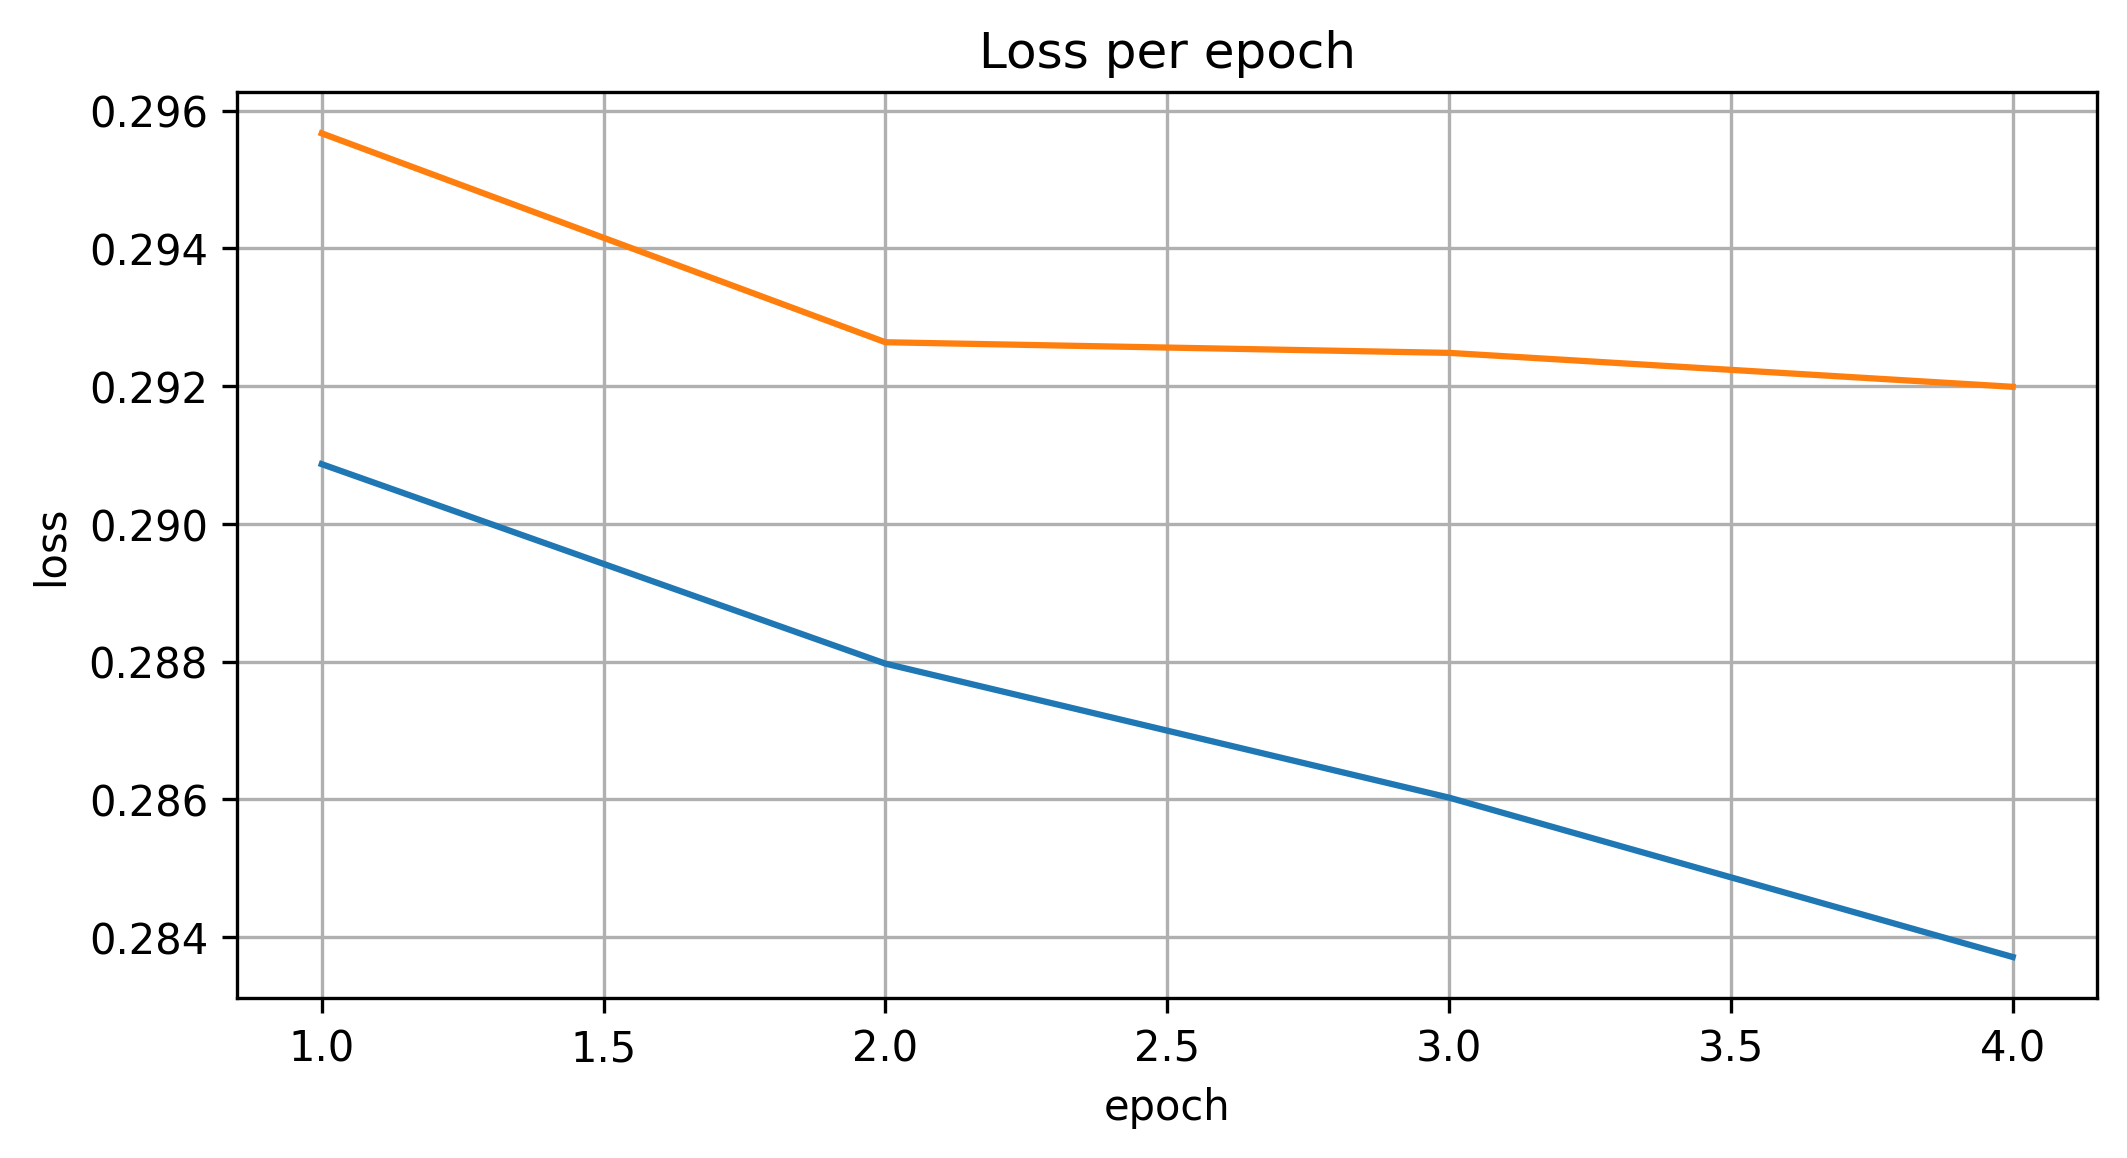

In [24]:
y1 = epoch_train_loss
x1 = np.arange(1,len(epoch_train_loss)+1)

y2 = epoch_val_loss
x2 = np.arange(1,len(epoch_val_loss)+1)

fig = plt.figure(figsize=(8,4), dpi=300)
plt.plot(x1,y1,label="train")
plt.plot(x2,y2,label="validation")

plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)

plt.show()

# plt.savefig('./NER/NER_loss_epoch', fmt='jpg',dpi=300)